In [1]:
# Initialization
import matplotlib.pyplot as plt
import numpy as np

# Importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library.standard_gates import ZGate

# Import basic plot tools
from qiskit.visualization import plot_histogram

from math import pi

I first create a function that returns the binary representation of the indices of integers that meet the condition: the binary representation is such that two adjacent bits are different.

I consider vectors with random values of size $N = 2^n$ with m bits in length for each element. We denote t numbre of integers which verify the condition.

In [2]:
# Write integers in binary representation

def integer_to_bit(l:list, m:int):
    p = []
    for i in l:
        p.append(bin(i)[2:].zfill(m))
    return p

In [3]:
# Find the indices of integers whose binary representation is such that two adjacent bits are different

def solution_indices(l:list, m:int):
    p = []
    
    # Verify the condition for each string
    for i in range (len(l)):
        s = 0
        for k in range (len(l[0])-1):
            if l[i][k] != l[i][k+1]: 
                s+=1
        if s == m - 1:
            p.append(i)
    return p

In [4]:
# Return the binary representation of the indices of integers that verify the previous condition

def sol(l:list, n:int, m:int):
    
    list_indices = [i for i in range(2**n)]
    list_integers_bit = integer_to_bit(l, m)
    list_solution_indices = solution_indices(list_integers_bit, m) 
   
    # Write the indices of integers in binary representation
    list_indices_bit = integer_to_bit(list_indices, n)
    
    list_states = []
    for i in list_solution_indices:
        list_states.append(list_indices_bit[i])
    
    return list_states    

In [5]:
# try the function sol on the examples [1,5,7,10] and [1,5,4,2]

l1 =  [1,5,4,2]
n1 = 2
m1 = 3
print(sol(l1, n1 , m1))

l = [1,5,7,10]
n = 2
m = 4
print(sol(l, n , m))

['01', '11']
['01', '11']


I then implement Grover's algorithm to create a quantum state that is a superposition of solution indices. We denote:

<ul>
<li>The equal superposition state: $| s \rangle = 1/\sqrt{N} \sum_{x=0}^{N-1}| x \rangle $</li>
<li>Sum over all x which are solutions to our problem: $| w \rangle = 1/\sqrt{T} \sum_{x}| x \rangle $</li>
<li>Sum over all x which are not solutions to our problem: $| s^{'} \rangle = 1/\sqrt{N-T} \sum_{x}| x \rangle $
</li>
</ul>

Step 1: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is constructed from $| s \rangle = H^{\otimes n}| 0 \rangle ^{n}$.

Step 2: We repeate the application of a quantum subroutine, know as the Grover iteration. The Grover iteration may be broken up into four steps:
<ul>
<li>We apply the oracle reflection $U_f$ to the state $| s \rangle$. Geometrically this corresponds to a reflection of the state $| s \rangle$ about $| s^{'} \rangle$.</li>
<li>We now apply an additional reflection $U_s$ about the state $| s \rangle$: $U_s = 2| s \rangle \langle s|- 1$. Geometrically this corresponds to a reflection of the state $U_f | s \rangle$ about $| s \rangle$.</li>
</ul>

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $| s \rangle$ closer towards the state $| w \rangle$.

In [6]:
# Initialise by applying a H-gate to 'qubits' in qc

def initialization(n:int):
    qr = QuantumRegister(n, "q")
    qc = QuantumCircuit(qr)
    
    for q in range(n):
        qc.h(qr[q])
    qc.barrier()
    return qc

In [7]:
# Create a phase oracle O

def phase_oracle(list_states:list, n:int):

    qr = QuantumRegister(n, "q")
    qc = QuantumCircuit(qr)
    
    for element in list_states:
        
        # Apply transformation |s> -> |11..1>
        for qubit in range(n):
            if element[::-1][qubit] == '0':
                qc.x(qr[qubit])

        # Apply transformation |11..1> -> - |11..1> using multi-controlled-Z
        gate = ZGate().control(n-1)  
        qc.append(gate, qr)
        
        # Apply transformation - |11..1> -> - |s> ->
        for qubit in range(n):
            if element[::-1][qubit] == '0':
                qc.x(qr[qubit])
    qc.barrier()
    return qc

In [8]:
# Create diffusion operator (U_s) for n qubits

def phase_diffuser(n:int): 
    qr = QuantumRegister(n, "q")
    qc = QuantumCircuit(qr)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(n):
        qc.h(qr[qubit])
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(n):
        qc.x(qr[qubit])
        
    # Apply multi-controlled-Z gate |11..1> -> - |11..1> 
    gate = ZGate().control(n-1)
    qc.append(gate, qr) 
    
    # Apply transformation |11..1> -> |00..0> 
    for qubit in range(n):
        qc.x(qr[qubit])
    
    # Apply transformation |00..0> -> |s>            # We can ignore the global phase of -1
    for qubit in range(n):
        qc.h(qr[qubit])
    qc.barrier()
    
    return qc

In [9]:
# Create Grover's circuit

def grover_circuit(list_states:list, n:int, number_iterations:int): 
    qr = QuantumRegister(n, "q")
    qc = QuantumCircuit(qr)
    
    qc = qc.combine(initialization(n))
    for i in range(number_iterations):
        qc = qc.combine(phase_oracle(list_states, n))
        qc = qc.combine(phase_diffuser(n))
    qc.measure_all()
    return qc

In [10]:
def result(qc): 
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend)
    return plot_histogram(job.result().get_counts(), color='midnightblue')

I apply the Grover's algorithm on the example [1,5,7,10]

['01', '11']


<ipython-input-9-b5b7ba271b4c>:7: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = qc.combine(initialization(n))


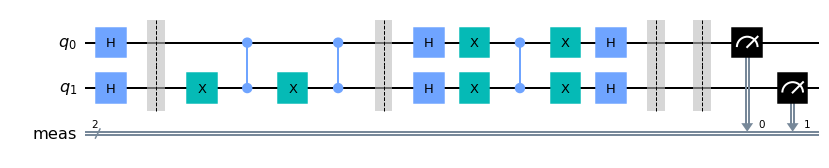

In [11]:
l = [1,5,7,10]
n = 2
m = 4

print(sol(l, n , m))
qc = grover_circuit(list_states = sol(l, n , m), n = 2, number_iterations = 1)
qc.draw('mpl')

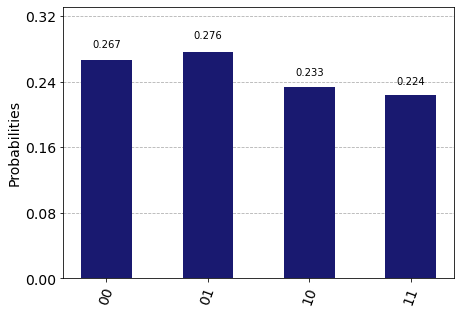

In [12]:
result(qc)

Now we will test Grover's algorithm on other different examples, to check if the implemented algorithm does not work or if [1,5,7,10] is a particular case.

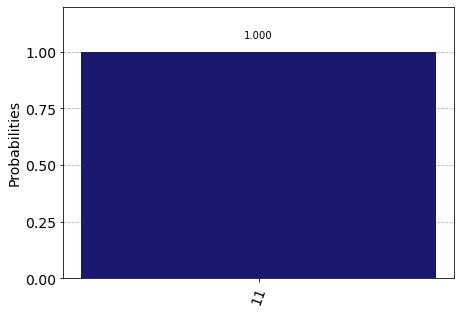

In [13]:
qc1 = grover_circuit(list_states = ['11'], n = 2, number_iterations = 1)
result(qc1)

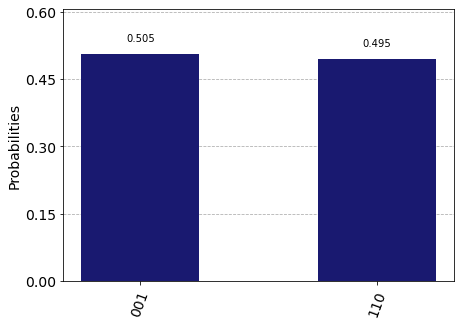

In [14]:
qc2 = grover_circuit(list_states = ['110', '001'], n = 3, number_iterations = 1)
result(qc2)

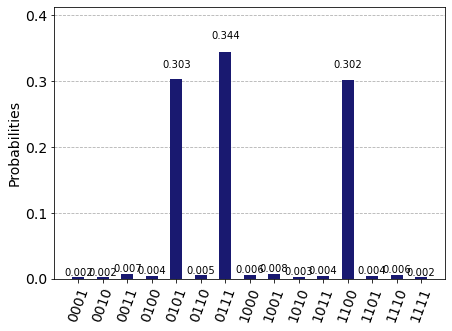

In [15]:
qc3 = grover_circuit(list_states = ['1100', '0101', '0111'], n = 4, number_iterations = 1)
result(qc3)

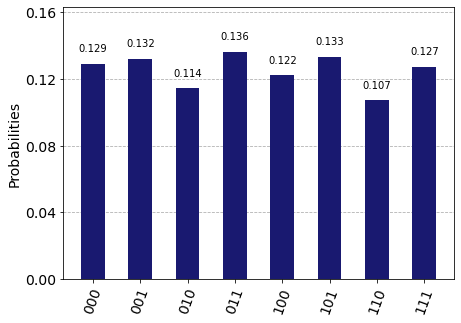

In [16]:
qc4 = grover_circuit(list_states = ['110', '001', '011', '101'], n = 3, number_iterations = 1)
result(qc4)

# Interpretation

We observe that the algorithm did not work for the two cases where we want to create a superposition of states ['01', '11'] and
['110', '001', '011', '101']. 

After trying to create the superposition of several other states, I noticed that the algorithm does not work when the number of solutions T (the superposed states that the algorithm creates) is equal to half the number of input integers $N/2 = 2^n/2$. Indeed, for the case ['01', '11'] there are two solutions and 4 input integers.

<img src="iterations.jpg" width="600" />
To interpret this result, I tried to understand what the algorithm does in the particular case ['01', '11'] using its graphical  representation as shown in the figure above. We notice that it behaves like a periodic function (I did not make a rigorous proof). In fact, after each iteration of the rotation transformation (phase oracle + phase diffuser) the algorithm returns the superposition of all states with equal probabilities.

The problem thus results from the fact that the initial state $| s \rangle$ is not adapted to the cases where $t = 2^{n-1}$ and in particular to the case ['01', '11']. 

I proposed two solutions to solve this problem: 

### First solution:

#### The case of ['01', '11']

Following the previous reasoning, I considered changing the initial state $1/2 (| 00\rangle + | 01\rangle + | 10\rangle + | 11\rangle) $ , and during the initialization instead of applying only Hadamard $H^{\otimes 2}$, I tried $H^{\otimes 2}Rx(\pi/9, 0)$. Therefore, I assumed $| \psi \rangle = H^{\otimes 2}Rx(\pi/9, 0)| 00 \rangle$ is the initial state. 

In the graphical representation, we will have an angle between the initial state $| \psi\rangle$ and the state $1/2 (| 00\rangle + | 10\rangle) $ different from $\pi/4$. 

Then, in the phase diffusion, I made the reflection about the state $| \psi \rangle$ (normally the diffusion phase represents the reflection about the uniform superposition $| s\rangle$). 

I chose the gate $Rx(\pi/9, 0)$ to create a superposition of states with different probabilities (the choice of the gate was arbitrary).

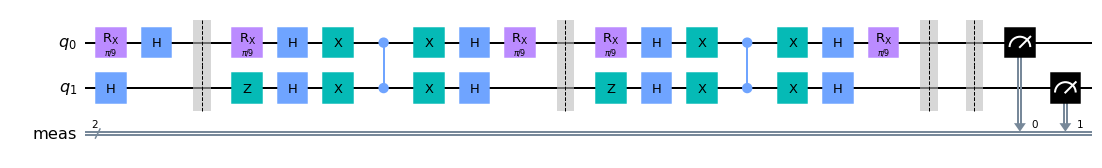

In [17]:
list_states = ['01','11']
n = 2
number_iterations = 2

qr = QuantumRegister(n, "q")
qc = QuantumCircuit(qr)

# Initialization

qc.rx(pi/9, 0)
qc.h([0,1])
qc.barrier()

for i in range(number_iterations):
    # Phase oracle
    qc.z(1)
    
    # Phase diffuser 
    qc.rx(pi/9, 0)
    qc.h([0,1])
    qc.x([0,1])
    qc.cz(0,1)
    qc.x([0,1])
    qc.h([0,1])
    qc.rx(pi/9, 0)
    qc.barrier()
    
qc.measure_all()
qc.draw('mpl')

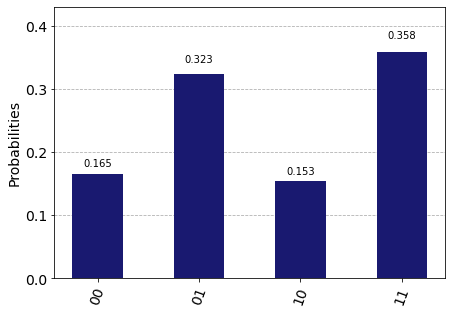

In [18]:
result(qc)

Finally, I obtained a promising result but not convincing enough.

### Second solution:

If we are working with n qubits, we can use n+1 qubits and then measure only the first n qubits.

For example, if we want to obtain the state  $1/\sqrt{2}(| 01\rangle + | 11\rangle) $, we look for the state $1/\sqrt{2}(| 010\rangle + | 110\rangle) $ and then measure the first two qubits. It's the same for the state $1/\sqrt{2}(| 00\rangle + | 11\rangle) $ or other in the case of two qubits, and for the state $1/2(| 110\rangle + | 001\rangle + | 011\rangle + | 101\rangle) $ in the case of 3 qubits.

In [19]:
# Create Grover's circuit

def grover_circuit_updated(list_states:list, n:int, number_iterations:int): 
    
    if len(list_states) == 2**(n-1):
        
        qc = QuantumCircuit(n+1, n)
        
        for i in range(len(list_states)):
            list_states[i] =  '0' + list_states[i]

        qc = qc.combine(initialization(n+1))
        for i in range(number_iterations):
            qc = qc.combine(phase_oracle(list_states, n+1))
            qc = qc.combine(phase_diffuser(n+1))
        
        qc.measure([*range(n)],[*range(n)])
    
    else:
        qc = grover_circuit(list_states, n, number_iterations)

    return qc

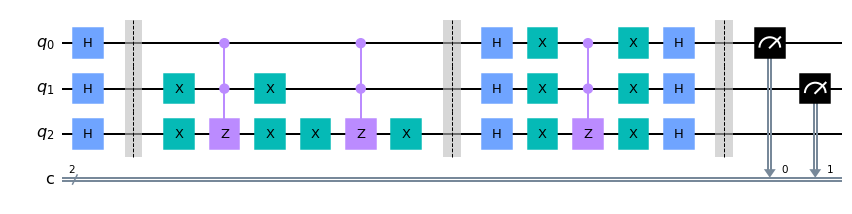

In [20]:
# Create the state 1/sqrt(2)*(|01⟩+|11⟩)

qc = grover_circuit_updated(list_states = ['01','11'], n = 2, number_iterations=1)
qc.draw('mpl')

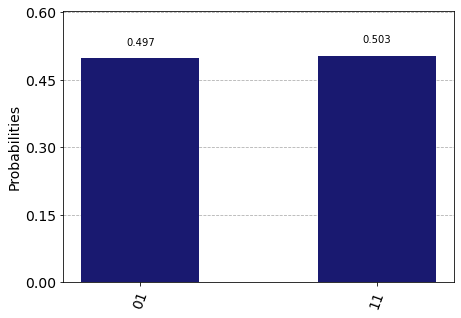

In [21]:
result(qc)

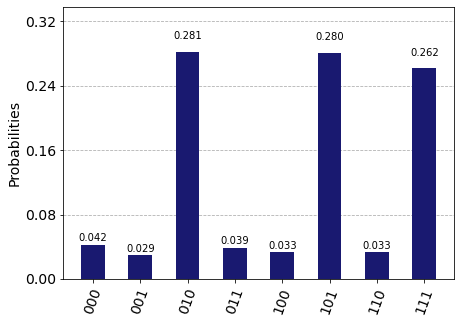

In [22]:
# Create the state 1/sqrt(3)*(|010⟩+|101⟩+|111⟩)

qc1 = grover_circuit_updated(list_states = ['010', '111', '101'], n = 3, number_iterations=1)
result(qc1)

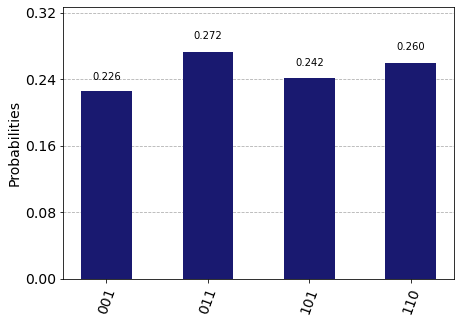

In [23]:
# Create the state 1/sqrt(3)*(|110⟩+|001⟩+|011⟩+|101⟩)

qc4 = grover_circuit_updated(list_states = ['110', '001', '011', '101'], n = 3, number_iterations = 1)
result(qc4)

In [24]:
# Create superposition of indices of the target solution given a vector of integers 

def sol_state(l, n , m, number_iterations):
    list_states = sol(l, n , m)
    qc = grover_circuit_updated(list_states, n, number_iterations)
    return result(qc)

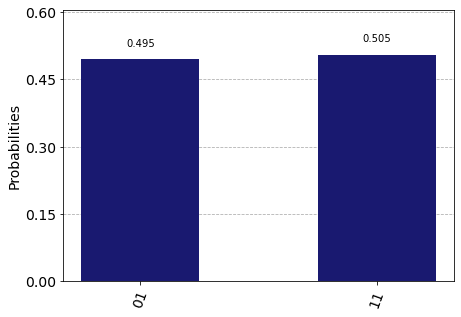

In [25]:
sol_state(l=[1,5,7,10], n=2 , m=4, number_iterations=1)

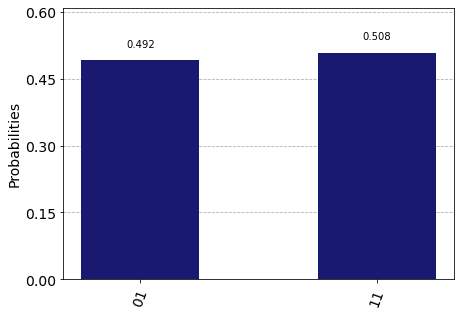

In [26]:
sol_state(l=[1,5,4,2], n=2 , m=3, number_iterations=1)

# References

[1] Michael A. Nielsen & Isaac L. Chuang (2010). [Quantum Computation and Quantum Information](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf)

[2] [Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html#2qubits)